In [1]:
import pandas as pd
pd.options.display.max_columns = None
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (3, 2.3)

In [2]:
df = pd.read_parquet('fhvhv_tripdata_2019-02_subset.parquet')

### Info

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 13136522 to 6237837
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   hvfhs_license_num     50000 non-null  object        
 1   dispatching_base_num  50000 non-null  object        
 2   originating_base_num  35910 non-null  object        
 3   request_datetime      49733 non-null  datetime64[ns]
 4   on_scene_datetime     33479 non-null  datetime64[ns]
 5   pickup_datetime       50000 non-null  datetime64[ns]
 6   dropoff_datetime      50000 non-null  datetime64[ns]
 7   PULocationID          50000 non-null  int64         
 8   DOLocationID          50000 non-null  int64         
 9   trip_miles            50000 non-null  float64       
 10  trip_time             50000 non-null  int64         
 11  base_passenger_fare   50000 non-null  float64       
 12  tolls                 50000 non-null  float64       
 13  bcf         

### Sample contents

In [4]:
df.head

<bound method NDFrame.head of          hvfhs_license_num dispatching_base_num originating_base_num  \
index                                                                  
13136522            HV0003               B02764               B02764   
14133617            HV0003               B02617               B02617   
3909141             HV0003               B02875               B02875   
3513707             HV0005               B02510                 None   
10265972            HV0005               B02510                 None   
...                    ...                  ...                  ...   
5589911             HV0003               B02875               B02875   
18946185            HV0003               B02617               B02617   
13565899            HV0003               B02883               B02883   
17523625            HV0005               B02510                 None   
6237837             HV0003               B02617               B02617   

            request_datetime   on

### Unique values

In [5]:
df.nunique()

hvfhs_license_num           4
dispatching_base_num       32
originating_base_num       30
request_datetime        49134
on_scene_datetime       33182
pickup_datetime         49426
dropoff_datetime        49427
PULocationID              255
DOLocationID              257
trip_miles               2692
trip_time                3631
base_passenger_fare      6149
tolls                     790
bcf                       409
sales_tax                 924
congestion_surcharge        3
airport_fee                 0
tips                      855
driver_pay               5536
shared_request_flag         2
shared_match_flag           2
access_a_ride_flag          1
wav_request_flag            2
wav_match_flag              0
dtype: int64

|column|nunique|
|:--------------------:|:---------:|
|hvfhs_license_num     |        4|
|dispatching_base_num  |       33|
|originating_base_num  |       33|
|request_datetime      |  2367057|
|on_scene_datetime     |  2306904|
|pickup_datetime       |  2366240|
|dropoff_datetime      |  2366900|
|PULocationID          |      263|
|DOLocationID          |      263|
|trip_miles            |    10548|
|trip_time             |    10472|
|base_passenger_fare   |    27299|
|tolls                 |     4038|
|bcf                   |     1405|
|sales_tax             |     3055|
|congestion_surcharge  |        3|
|airport_fee           |        0|
|tips                  |     4348|
|driver_pay            |    21625|
|shared_request_flag   |        2|
|shared_match_flag     |        2|
|access_a_ride_flag    |        1|
|wav_request_flag      |        2|
|wav_match_flag        |        0|

In [6]:
#df.isnull().sum()

### Null values

In [7]:
df.isnull().sum()

hvfhs_license_num           0
dispatching_base_num        0
originating_base_num    14090
request_datetime          267
on_scene_datetime       16521
pickup_datetime             0
dropoff_datetime            0
PULocationID                0
DOLocationID                0
trip_miles                  0
trip_time                   0
base_passenger_fare         0
tolls                       0
bcf                         0
sales_tax                   0
congestion_surcharge     1286
airport_fee             50000
tips                        0
driver_pay                  0
shared_request_flag         0
shared_match_flag           0
access_a_ride_flag          0
wav_request_flag            0
wav_match_flag          50000
dtype: int64

## What I learned from the first looks at the data:

1. (missing values) 'originating_base_num' seems to contain the same value as 'dispatching_base_num' but has a lot more nulls.  
Let's try to fill missing values from these two and drop one.

2. (missing values) Some 'request_datetime' is missing. Let's fill in with the mean time difference between it and 'pickup_datetime'.

3. (missing values) A third of 'on_scene_datetime' is missing. Let's fill in with the mean time difference between it and 'pickup_datetime'.

4. (data quality issue) Something I don't understand is why sometimes 'shared_request_flag' is 'N' but 'shared_match_flag' is 'Y'.  
Does the service force the user to be on a shared ride? **I might combine these two columns with OR.**

5. (data quality issue) 'access_a_ride_flag' is all 'N' in this dataset. 'wav_match_flag' is all 'NaN' in this dataset. Drop these.

6. (problem scope) Let's try to predict the base passenger fare, **without other added costs**.  
So let's drop \['tolls','bcf','sales_tax','congestion_surcharge','airport_fee','tips','driver_pay'\].

7. (problem approach) Real-valued features are the easiest to handle by both linear and tree-based models.  
There are two such columns: **\['trip_miles','trip_time'\]**.  
**hvfhs_license_num** is a categorical feature with 4 classes. Manageable.  
Let's train using only these three features in the first pass.  





In [8]:
# process the issues spotted above

# use wellkown labels for license num
df['hvfhs_license_num'] = df['hvfhs_license_num'].map(
    {'HV0002':'Juno' ,'HV0003':'Uber', 'HV0004':'Via', 'HV0005':'Lyft'})

# combine two base_num columns
srs1 = df['dispatching_base_num'].copy()
srs2 = df['originating_base_num'].copy()
# fill null in one column with the other column
srs1[srs1.isnull()]=srs2[srs1.isnull()]
# save one back to df
df = df.assign(starting_base_num=srs1)

# fill request_datetime
tdiff = df['pickup_datetime'] - df['request_datetime']
df.loc[df['request_datetime'].isnull(), 'request_datetime'] = \
df['pickup_datetime'][df['request_datetime'].isnull()] - tdiff.mean()

# fill on_scene_datetime
tdiff = df['pickup_datetime'] - df['on_scene_datetime']
df.loc[df['on_scene_datetime'].isnull(), 'on_scene_datetime'] = \
df['pickup_datetime'][df['on_scene_datetime'].isnull()] - tdiff.mean()

# combine two flags about shared rides
srs1 = df['shared_request_flag'].map({'Y':True ,'N':False})
srs2 = df['shared_match_flag'].map({'Y':True ,'N':False})
srs3 = srs1 | srs2
df = df.assign(shared_flag_or=srs3)

# turn Y/N into actual binary values
df['wav_request_flag'] = df['wav_request_flag'].map({'Y':True ,'N':False})

# drop extra columns
df = df.drop(columns=['dispatching_base_num','originating_base_num','tolls','bcf','sales_tax',
                            'congestion_surcharge','airport_fee','tips','driver_pay',
                            'shared_request_flag','shared_match_flag','access_a_ride_flag','wav_match_flag'])


### check to see if unwanted columns are out, new columns are in, and missing values are filled

In [9]:
df.head

<bound method NDFrame.head of          hvfhs_license_num    request_datetime             on_scene_datetime  \
index                                                                          
13136522              Uber 2019-02-19 09:05:48 2019-02-19 09:28:59.000000000   
14133617              Uber 2019-02-20 20:50:43 2019-02-20 20:50:57.000000000   
3909141               Uber 2019-02-06 13:09:08 2019-02-06 13:11:01.000000000   
3513707               Lyft 2019-02-05 19:05:56 2019-02-05 19:06:23.039547179   
10265972              Lyft 2019-02-15 08:17:03 2019-02-15 08:21:15.039547179   
...                    ...                 ...                           ...   
5589911               Uber 2019-02-08 20:09:41 2019-02-08 20:18:56.000000000   
18946185              Uber 2019-02-27 11:23:19 2019-02-27 11:27:08.000000000   
13565899              Uber 2019-02-19 22:52:36 2019-02-19 22:52:47.000000000   
17523625              Lyft 2019-02-25 09:01:55 2019-02-25 09:06:35.039547179   
6237837   

In [10]:
df.isnull().sum()

hvfhs_license_num      0
request_datetime       0
on_scene_datetime      0
pickup_datetime        0
dropoff_datetime       0
PULocationID           0
DOLocationID           0
trip_miles             0
trip_time              0
base_passenger_fare    0
wav_request_flag       0
starting_base_num      0
shared_flag_or         0
dtype: int64

# Visually check data

We pared down the columns and fill in (most) null values. Now let's check the distribution of the data.

hvfhs_license_num
Uber    33478
Lyft    11690
Juno     2431
Via      2401
Name: count, dtype: int64

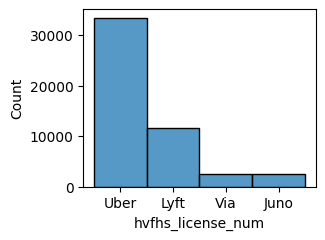

In [11]:
#we might have unbalanced data: very few rides by Juno?
sns.histplot(df['hvfhs_license_num'])
df['hvfhs_license_num'].value_counts()

Juno and Via have a fraction of the number of rides compared to Uber and Lyft but is definitely enough for data splitting.

<Axes: xlabel='request_datetime', ylabel='Count'>

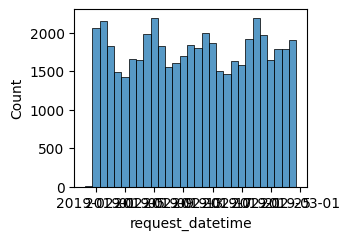

In [12]:
sns.histplot(df['request_datetime'].dt.date)   # bins by day


(Feb. 2019 starts on a Friday and ends on a Thursday.) The number of rides are higher on weekends than weekdays. I might make a feature that captures that.

<Axes: xlabel='request_datetime', ylabel='Count'>

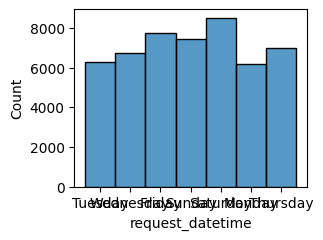

In [13]:
sns.histplot(df['request_datetime'].dt.day_name())

<Axes: xlabel='request_datetime', ylabel='Count'>

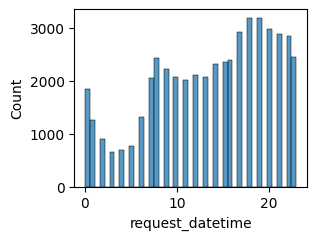

In [14]:
sns.histplot(df['request_datetime'].dt.hour)


The number of rides depend on hour of the day. I can make this a new feature.

<Axes: xlabel='PULocationID', ylabel='Count'>

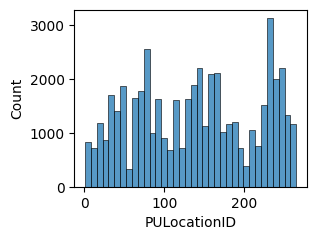

In [15]:
sns.histplot(df['PULocationID'])

<Axes: xlabel='DOLocationID', ylabel='Count'>

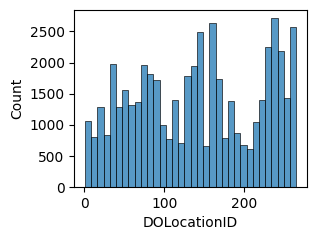

In [16]:
sns.histplot(df['DOLocationID'])

(-1.0, 50.0)

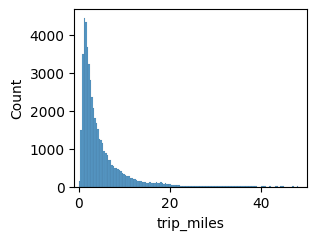

In [17]:
ax = sns.histplot(df['trip_miles'])
ax.set_xlim(-1, 50)

Maximum value of 'trip_miles' is 469.26 while the median is 2.88. The distribution is right-skewed. Let's do log1p. 'trip_time' has the same problem.

<Axes: xlabel='trip_miles', ylabel='Count'>

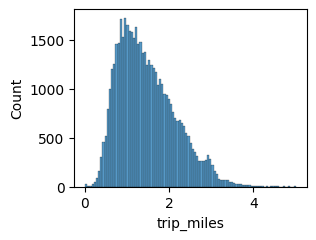

In [18]:
sns.histplot(np.log1p(df['trip_miles']))

<Axes: xlabel='trip_time', ylabel='Count'>

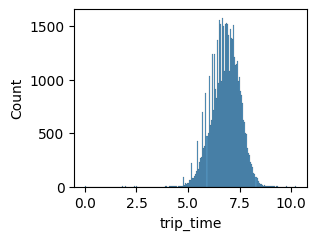

In [19]:
sns.histplot(np.log1p(df['trip_time']))

<Axes: xlabel='base_passenger_fare', ylabel='Count'>

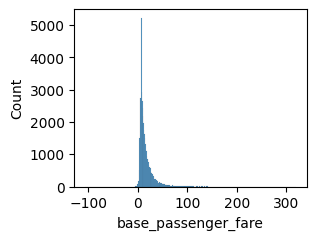

In [20]:
sns.histplot(df['base_passenger_fare'])


In [21]:
df['base_passenger_fare'].describe()

count   50000.000
mean       15.686
std        15.681
min      -107.040
25%         6.690
50%        10.770
75%        18.980
max       320.380
Name: base_passenger_fare, dtype: float64

In [22]:
(df['base_passenger_fare']<0).sum()

np.int64(178)

Some (<1%) of prices are negative. Even though only a small part of data is impacted, it reflects a something that we don't understand in the price setting process or data corruption. And it prevents us from applying a log transform. 

## Findings of visual inspection

1. (Data quality) The ride share company column is imbalanced, but shouldn't be an issue given the large number of observations.
2. (Feature engineering) Day of the week and hour of the day are good summaries of the datetime columns.
3. (Feature scaling and transformation) Trip distance and duration are very right skewed and should be log-transformed.
4. (Feature scaling and transformation) Trip fare (y) is also very right skewed, but in some observations it is negative. I decided to not apply any transform and just see what happens...
   What happens is, as I will discover by accident, that 3. and 4. are not compatible. See 3_modeling_full.ipynb.
5. (Feature engineering) Driver match wait time, even though happens after the price is set, might be informative.

In [23]:
# execute the ideas above

# apply log transform to right-skewed data
df= df.assign(trip_miles_log1p=np.log1p(df['trip_miles']))
df= df.assign(trip_time_log1p=np.log1p(df['trip_time']))

# turn these into categorical labels
df["DOLocationID"] = df["DOLocationID"].astype(str)
df["PULocationID"] = df["PULocationID"].astype(str)

# engineer new features
# day of the week
df = df.assign(day_of_week=df['request_datetime'].dt.day_name())
# hour of the day
df = df.assign(hour_of_day=df['request_datetime'].dt.hour)
df["hour_of_day"] = df["hour_of_day"].astype(str)

# demand of the ride
# the idea is, with fixed supply, demand drive up price
# with the same distance, a ride to the airport might be more expensive 
# a ride from the venue after a concert is probably more expensive than other times
# but I haven't figured out how to estimate this that 
# 1. does not cause data leaking
# and 2. works for a single test datapoint with no context
# So I won't include it for this project

# I realize that datetime cannot be treated as a numeric variable
# we can instead use the ride wait time = pickup_datetime - request_datetime
# which is a good numeric variable
# and captures supply-demand
# the only problem is that in real life, price is fixed before the wait time realizes
# but I'm sure the ride share companies have a way to estimate the wait time and feed it to price prediction
# of course it also needs to be log transformed
df = df.assign(wait_time_sec_log1p=np.log1p((df['pickup_datetime']-df['request_datetime']).dt.total_seconds()))

In [24]:
df.isnull().sum()

hvfhs_license_num      0
request_datetime       0
on_scene_datetime      0
pickup_datetime        0
dropoff_datetime       0
PULocationID           0
DOLocationID           0
trip_miles             0
trip_time              0
base_passenger_fare    0
wav_request_flag       0
starting_base_num      0
shared_flag_or         0
trip_miles_log1p       0
trip_time_log1p        0
day_of_week            0
hour_of_day            0
wait_time_sec_log1p    0
dtype: int64

# Let's train models now
My idea is to compare linear regression and boosted tree models, with a few curated features vs. with all features (including hundreds of one-hot features), each with hyperparameter tuning (several strengths of L1 regularization and of L2 regularization for linear regression, and for XGBoost: max_depth, learning_rate, min_child_weight, and subsample).  

All of the above variations will be trained on 72% and evaluated on 18% of the data. The top performers will be evaluated on a 5-fold CV. The 1st place winner will get tested on the 10% test split as a final evaluation of how the project went.

# Save the final dataframe and move on to the modeling notebook

In [25]:
# again drop the unwanted columns
df = df.drop(columns=["request_datetime","on_scene_datetime","pickup_datetime","dropoff_datetime"])

# a small set of features that should be easy to handle (no huge one-hot)
# all numerical features are easy
numerics = ["wait_time_sec_log1p","trip_miles_log1p","trip_time_log1p"]
# short list of categoricals
curated_cat = ["hvfhs_license_num","wav_request_flag","shared_flag_or","day_of_week","hour_of_day"]
# other categoricals
other_cat = ["PULocationID","DOLocationID"]

In [26]:
import pickle

with open("cleaned_df_features.pkl", "wb") as f:
    pickle.dump((df, numerics, curated_cat, other_cat), f)